[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/weaviate/recipes/blob/main/integrations/operations/aimon/reranking_and_evaluation.ipynb)

# Improve Quality of your LLM Application and RAG Relevance with AIMon

## Overview

In this tutorial, we'll help you build a retrieval-augmented generation (RAG) chatbot that answers questions on the [meeting bank dataset](https://meetingbank.github.io/).

In this tutorial you will learn to:

*   Build an LLM application that answers a user's query related to the meeting bank dataset.
*   Define, measure and improve the quality of your LLM application.
*   Improve the RAG relevance score significanly (as high as 97% although your mileage may vary)


## Tech Stack

#### *Vector Database*

For this application, we will use [Weaviate](https://weaviate.io/platform), which is an open-source, AI-native vector database. We will also use Weaviate's fast embedding computation service.

#### *LLM Framework*
[LlamaIndex](https://www.llamaindex.ai/) is an open-source data orchestration framework that simplifies building large language model (LLM) applications by facilitating the integration of private data with LLMs, enabling context-augmented generative AI applications through a Retrieval-Augmented Generation (RAG) pipeline. We will use LlamaIndex for this tutorial since it offers a good amount of flexibility and better lower level API abstractions.

#### *LLM Output Quality Evaluation*
[AIMon](https://www.aimon.ai) offers proprietary Judge models for Hallucination, Context Quality issues, Instruction Adherence of LLMs, Retrieval Quality and other LLM reliability tasks. We will use AIMon to judge the quality of the LLM application.


In [ ]:
!pip3 install -U gdown requests aimon llama-index-core weaviate-client llama-index-vector-stores-weaviate llama-index-postprocessor-aimon-rerank llama-index-embeddings-openai llama-index-llms-openai datasets fuzzywuzzy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.6/366.6 kB 5.0 MB/s eta 0:00:00


# Pre-requisites

1. Signup for an [AIMon account here](https://docs.aimon.ai/quickstart).

  Add this secret to the Colab Secrets (the "key" symbol on the left panel)

  * AIMON_API_KEY

2. Signup for a [Weaviate account here](https://weaviate.io/), create a sandbox cluster, and set the following keys in the Colab secrets.
  * WCD_URL (REST Endpoint of your Weaviate cluster)
  * WCD_API_KEY (Admin API Key of your Weaviate cluster)

3. Signup for an [OpenAI account here](https://platform.openai.com/docs/overview) and add the following key in Colab secrets:
  * OPENAI_API_KEY



### Required API keys

In [ ]:
import os

# Check if the secrets are accessible
from google.colab import userdata

# Get this from the AIMon UI
aimon_key = userdata.get('AIMON_API_KEY')

wcd_url = userdata.get("WCD_URL")
wcd_api_key = userdata.get("WCD_API_KEY")
openai_key = userdata.get("OPENAI_API_KEY")

# Set OpenAI key as an environment variable as well
os.environ['OPENAI_API_KEY'] = openai_key

# Dataset

We will use the [MeetingBank](https://meetingbank.github.io/) dataset which is a benchmark dataset created from the city councils of 6 major U.S. cities to supplement existing datasets. It contains 1,366 meetings with over 3,579 hours of video, as well as transcripts, PDF documents of meeting minutes, agenda, and other metadata.

For this exercise, we have created a smaller dataset. It can be found [here](https://drive.google.com/drive/folders/1v3vJahKtadi_r-8VJAsDd2eaiSRenmsa?usp=drive_link).

In [ ]:
# Delete the dataset folder if it already exists

import shutil

folder_path = "/content/meetingbank_train_split.hf"

if os.path.exists(folder_path):
    try:
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except Exception as e:
        print(f"Error deleting folder '{folder_path}': {e}")
else:
    print(f"Folder '{folder_path}' does not exist.")


Folder '/content/meetingbank_train_split.hf' and its contents deleted successfully.


In [ ]:
# Download the dataset locally
!gdown https://drive.google.com/uc?id=1bs4kwwiD30DUeCjuqEdOeixCuI-3i9F5
!gdown https://drive.google.com/uc?id=1fkxaS8eltjfkzws5BRXpVXnxl2Qxwy5F

Downloading...
From: https://drive.google.com/uc?id=1bs4kwwiD30DUeCjuqEdOeixCuI-3i9F5
To: /content/meetingbank_train_split.tar.gz
100% 1.87M/1.87M [00:00<00:00, 26.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fkxaS8eltjfkzws5BRXpVXnxl2Qxwy5F
To: /content/score_metrics_relevant_examples_2.csv
100% 163k/163k [00:00<00:00, 72.2MB/s]


In [ ]:
import tarfile
from datasets import load_from_disk

tar_file_path =  "/content/meetingbank_train_split.tar.gz"
extract_path = "/content/"

# Extract the file
with tarfile.open(tar_file_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print(f"Extracted to: {extract_path}")

train_split = load_from_disk(extract_path+"meetingbank_train_split.hf")

Extracted to: /content/


### Queries

Below are the 12 queries that we will run on the transcript above

In [ ]:
import pandas as pd
queries_df = pd.read_csv('/content/score_metrics_relevant_examples_2.csv')

In [ ]:
queries_df['Query'].to_list()

['What was the key decision in the meeting?',
 'What are the next steps for the team?',
 'Summarize the meeting in 10 words.',
 'What were the main points of discussion?',
 'What decision was made regarding the project?',
 'What were the outcomes of the meeting?',
 'What was discussed in the meeting?',
 'What examples were discussed for project inspiration?',
 'What considerations were made for the project timeline?',
 'Who is responsible for completing the tasks?',
 'What were the decisions made in the meeting?',
 'What did the team decide about the project timeline?']

# Metric Definition

This quality score metric will help us understand how good the LLM responses are for the set of queries above. To measure quality of our application, we will run a set of queries and aggregate the quality scores across all these queries.

LLM Application Quality Score is a combination of 3 individual quality metrics from AIMon:

1. **Hallucination Score** (hall_score): checks if the generated text is grounded in the provided context. A score closer to 1.0 means that there is a strong indication of hallucination and a score closer to 0.0 means a lower indication of hallucination. Hence, we will use (1.0-hall_score) here when computing the final quality score.
2. **Instruction Adherence Score** (ia_score): checks if all explicit instructions provided have been followed by the LLM. The higher the ia_score the better the adherence to instructions. The lower the score, the poorer the adherence to instructions.
3. **Retrieval Relevance Score** (rr_score): checks if the retrieved documents are relevant to the query. A score closer to 100.0 means perfect relevance of document to query and a score closer to 0.0 means poor relevance of document to query.

`quality_score = 0.35 * (1.0 - hall_score) + 0.35 * ia_score + 0.3 * rr_score`

In [ ]:
# We will check the LLM response against these instructions
instructions_to_evaluate = """
1. Ensure that the response answers all parts of the query completely.
2. Ensure that the length of the response is under 50 words.
3. The response must not contain any abusive language or toxic content.
4. The response must be in a friendly tone.
"""

In [ ]:
def compute_quality_score(aimon_response):
  retrieval_rel_scores = aimon_response.detect_response.retrieval_relevance[0]['relevance_scores']
  avg_retrieval_relevance_score = statistics.mean(retrieval_rel_scores) if len(retrieval_rel_scores) > 0 else 0.0
  hall_score = aimon_response.detect_response.hallucination['score']
  ia_score = aimon_response.detect_response.instruction_adherence['score']
  return (0.35 * (1.0 - hall_score) + 0.35 * ia_score + 0.3 * (avg_retrieval_relevance_score/100)) * 100.0

# Setup AIMon

As mentioned previously, AIMon will be used to judge the quality of the LLM application. [Documentation can be found here](https://docs.aimon.ai/).

In [ ]:
from aimon import Detect

aimon_config = {'hallucination': {'detector_name': 'default'},
                'instruction_adherence': {'detector_name': 'default'},
                'retrieval_relevance': {'detector_name': 'default'},
               }
task_definition = """
Your task is to grade the relevance of context document against a specified user query.
The domain here is a meeting transcripts.
"""

values_returned = ['context', 'user_query', 'instructions', 'generated_text', 'task_definition']

detect = Detect(
      values_returned=values_returned,
      api_key = userdata.get("AIMON_API_KEY"),
      config=aimon_config,
      publish=True, # This publishes results to the AIMon UI
      application_name="meeting_bot_app",
      model_name="OpenAI-gpt-4o-mini"
    )

## Instantiate the Weaviate client

In [ ]:
import weaviate
import weaviate.classes.config as wc
from weaviate.classes.init import Auth

client = weaviate.connect_to_weaviate_cloud(
    cluster_url=wcd_url,
    auth_credentials=Auth.api_key(wcd_api_key),

    headers={
    "X-OpenAI-Api-Key": openai_key,
    }
)

print("Weaviate Cloud Connection Successful" if client.is_ready() else "Error: Weaviate connection unsuccesful. Check your URL and API_KEY.")

Weaviate Cloud Connection Successful


### Create a Weaviate collection

We will use OpenAI's `text-embedding-3-small` model to create embeddings for the documents. These embeddings are created using [Weaviate's embedding service](https://weaviate.io/developers/wcs/embeddings) which offers a fast embedding computation option. Note that this option is not available in the open source version of Weaviate. To use the embedding service you need to have a cluster or a sandbox running in Weaviate cloud.

In [ ]:
# Note: This will delete your data stored in "MeetingBankDataset".and
# It will require you to re-import again.

# Delete the collection if it already exists
if (client.collections.exists("MeetingBankDataset")):
    client.collections.delete("MeetingBankDataset")

client.collections.create(
    name="MeetingBankDataset",

    vectorizer_config=wc.Configure.Vectorizer.text2vec_openai(model='text-embedding-3-small'),

    generative_config=wc.Configure.Generative.openai(model="gpt-4o-mini"),

    properties=[
        wc.Property(name="transcript", data_type=wc.DataType.TEXT),
        wc.Property(name="uid", data_type=wc.DataType.TEXT, skip_vectorization=True),
    ]

)

print("Successfully created collection: MeetingBankDataset.")

Successfully created collection: MeetingBankDataset.


### Ingest data to the Weaviate Collection

This step takes about 30 seconds to ingest ~4000 documents.

In [ ]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter()

collection = client.collections.get("MeetingBankDataset")

def preprocess_text(text):
    return " ".join(str(text).split())

with collection.batch.dynamic() as batch:
    for i, row in enumerate(train_split):
        try:
            transcript = preprocess_text(row["transcript"])
            chunks = splitter.split_text(transcript)

            for j, chunk in enumerate(chunks):
                properties = {
                    "transcript": chunk,
                    "uid": f"{row.get('uid', 'no-id')}_part{j+1}"
                }
                batch.add_object(properties)

        except Exception as e:
            print(f"Error at index {i}: {e}")

# Final status
failed_inserts = collection.batch.failed_objects
print(f"Failed inserts: {len(failed_inserts)}" if failed_inserts else "Data ingested into 'MeetingBankDataset' successfully.")

Data ingested into 'MeetingBankDataset' successfully.


# 1. Use Weaviate Vector Database for document retrieval

There are two main components we need to be aware of: Ingestion and RAG based Q&A. The ingestion pipeline processes the transcripts from the Meeting Bank dataset and stores it in the Weaviate Vector database. The RAG Q&A pipeline processes a user query by first retrieving the relevant documents from the vector store. These documents are then be used as grounding documents for the LLM to generate its response. We leverage AIMon to calculate the quality score and continuously monitor the application for [hallucination](https://docs.aimon.ai/detectors/hallucination), , [instruction adherence](https://docs.aimon.ai/detectors/instruction_adherence),  [context relevance](https://docs.aimon.ai/checker-models/context_relevance). These are the same 3 metrics we used to define the `quality` score above.


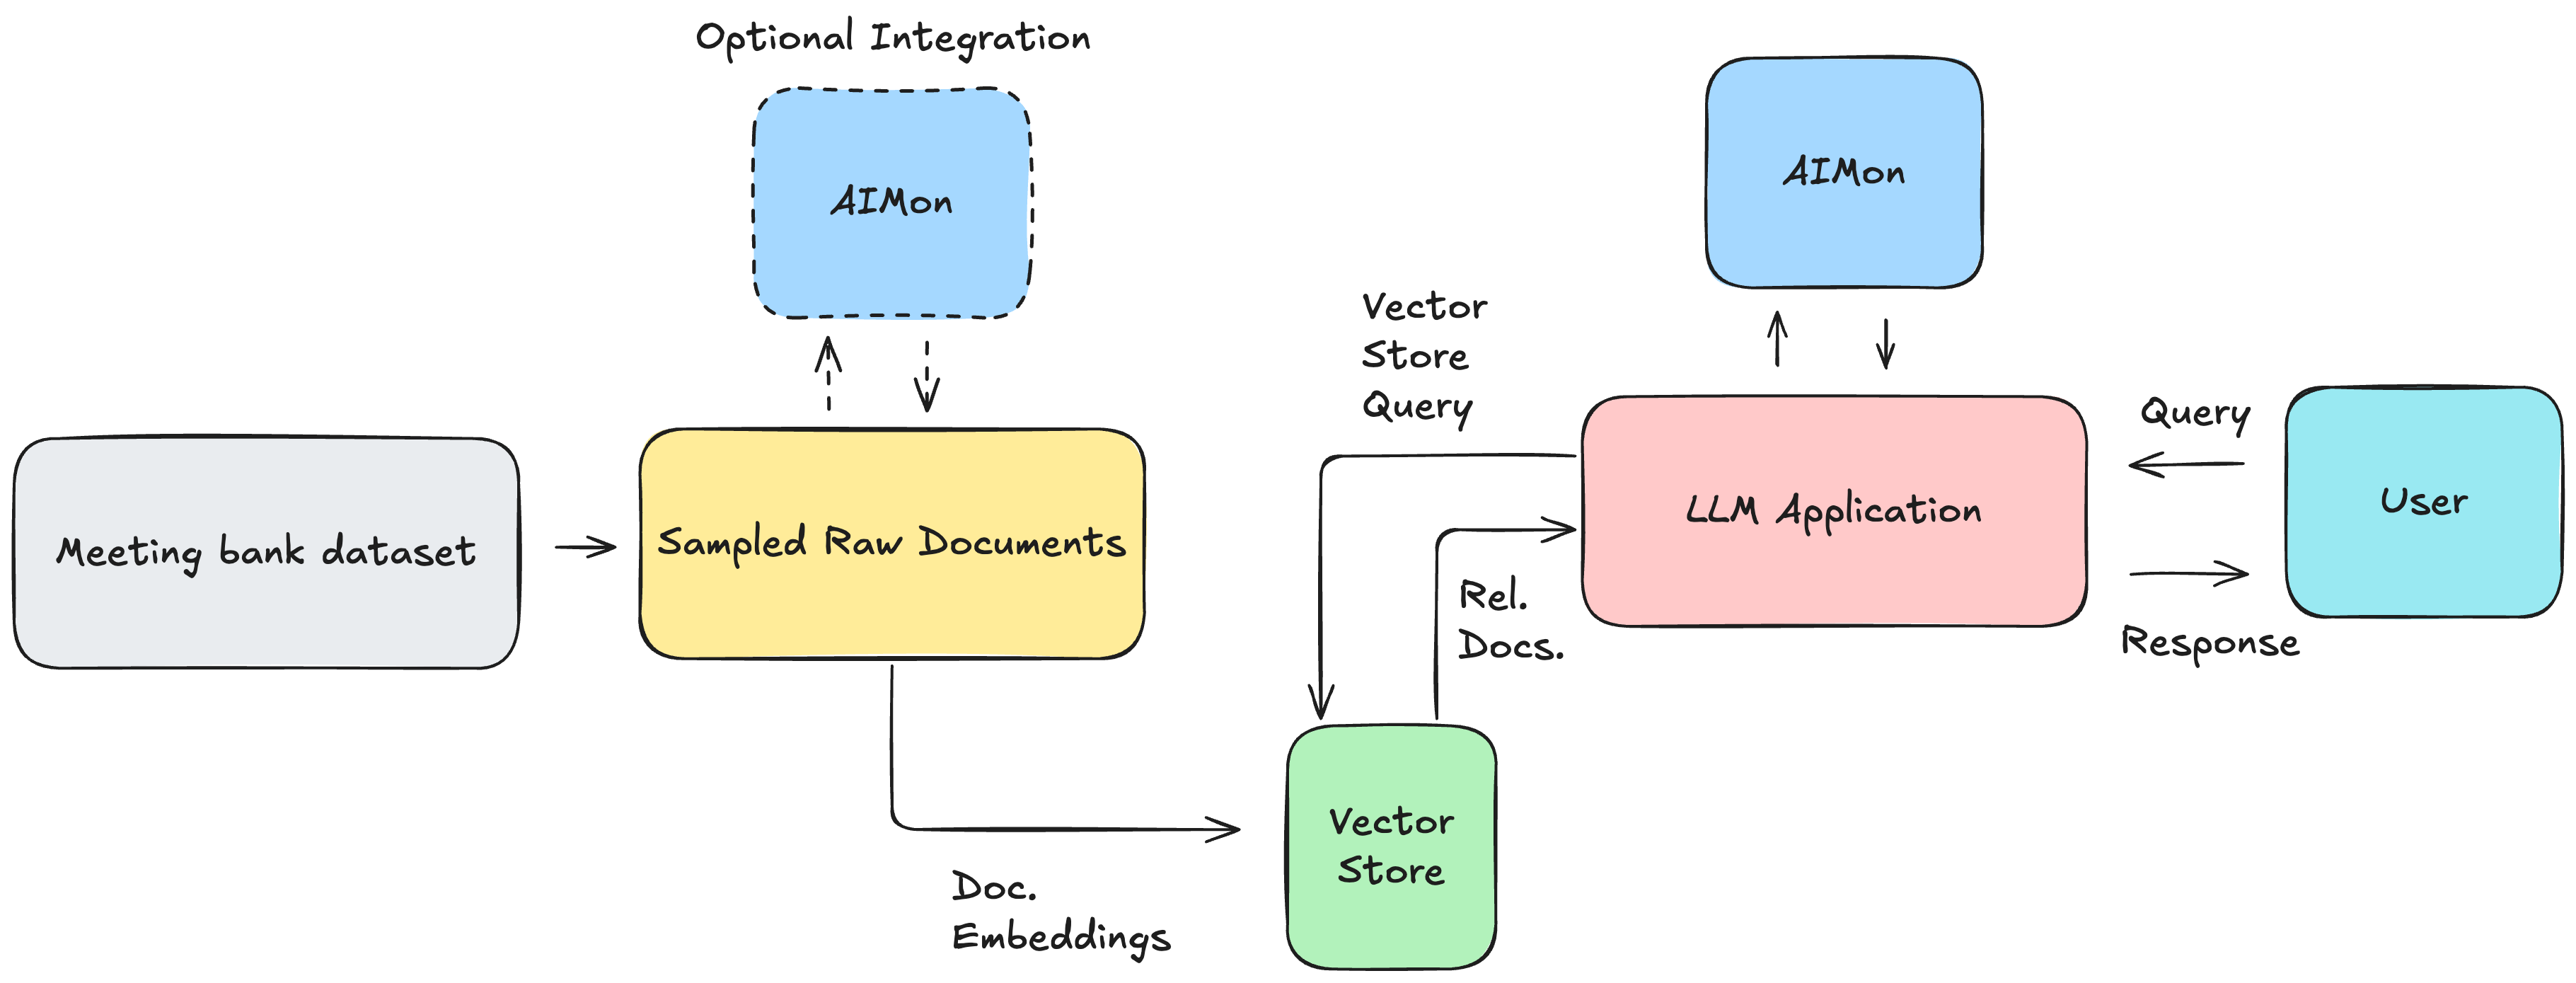

We will use LlamaIndex's query embedding to embed the input queries. This option uses the same Open AI embedding model `text-embedding-3-small` that was used to ingest the documents above.

In [ ]:
from llama_index.core.settings import Settings

from llama_index.embeddings.openai import OpenAIEmbedding
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

In the cells below, we will setup a LlamaIndex VectorStoreIndex, setup the LLM and build a LLamaIndex Query Engine that interfaces with the stored embeddings and the LLM to answer a user's questions.

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.weaviate import WeaviateVectorStore

vector_store = WeaviateVectorStore(weaviate_client=client, index_name="MeetingBankDataset", text_key="transcript")

index = VectorStoreIndex.from_vector_store(vector_store)

# The system prompt that will be used for the LLM
system_prompt = """
                Please be professional and polite.
                Answer the user's question in a single line.
                """

In [ ]:
## OpenAI's LLM, we will use GPT-4o-mini here since it is a fast and cheap LLM
from llama_index.llms.openai import OpenAI
llm = OpenAI(model="gpt-4o-mini", temperature=0.1, system_prompt = system_prompt)

We will use a [Hybrid search strategy](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo-Hybrid/) here. Hybrid search provides a balanced approach to using both the keyword based reverse index search and vector search.  The `alpha` parameter determines how much weight should be given to keyword search `bm25` v/s vector search (alpha = 0 -> bm25, alpha=1 -> vector search).

In [ ]:
query_engine = index.as_query_engine(llm = llm, vector_store_query_mode="hybrid", similarity_top_k=5, alpha=0.7)

At this point, the query engine. Next, we setup AIMon to help us measure quality scores. We use the same `@detect` decorator that was created in the previous cells above. The only additional code in `ask_and_validate` here is to help AIMon interface with LLamaIndex's retrieved document "nodes".  

In [ ]:
import logging

@detect
def ask_and_validate(user_query, user_instructions, query_engine=query_engine):

    response = query_engine.query(user_query)

    ## Nested function to retrieve context and relevance scores from the LLM response.
    def get_source_docs(chat_response):
      contexts = []
      relevance_scores = []
      if hasattr(chat_response, 'source_nodes'):
          for node in chat_response.source_nodes:
              if hasattr(node, 'node') and hasattr(node.node, 'text') and hasattr(node,
                                                                          'score') and node.score is not None:
                  contexts.append(node.node.text)
                  relevance_scores.append(node.score)
              elif hasattr(node, 'text') and hasattr(node, 'score') and node.score is not None:
                  contexts.append(node.text)
                  relevance_scores.append(node.score)
              else:
                  logging.info("Node does not have required attributes.")
      else:
          logging.info("No source_nodes attribute found in the chat response.")
      return contexts, relevance_scores

    context, relevance_scores = get_source_docs(response)
    return context, user_query, user_instructions, response.response, task_definition

Lets run through all the queries through the LlamaIndex query engine in the `queries_df` and compute the overall quality score using AIMon.

**NOTE: This will take about 2 mins**

In [ ]:
import time
import statistics

quality_scores_vdb = []
avg_retrieval_rel_scores_vdb = []
responses_adb = {}
ast = time.time()
for user_query in queries_df['Query'].to_list():
  _,_,_,llm_res,_,aimon_response = ask_and_validate(user_query, instructions_to_evaluate)
  # These show the average retrieval relevance scores per query.
  retrieval_rel_scores = aimon_response.detect_response.retrieval_relevance[0]['relevance_scores']
  avg_retrieval_rel_score_per_query = statistics.mean(retrieval_rel_scores) if len(retrieval_rel_scores) > 0 else 0.0
  avg_retrieval_rel_scores_vdb.append(avg_retrieval_rel_score_per_query)
  print("Avg. Retrieval relevance score across chunks: {} for query: {}".format(avg_retrieval_rel_score_per_query, user_query))
  quality_scores_vdb.append(compute_quality_score(aimon_response))
  responses_adb[user_query] = llm_res
print("Time elapsed: {} seconds".format(time.time() - ast))

Avg. Retrieval relevance score across chunks: 20.71450106313847 for query: What was the key decision in the meeting?
Avg. Retrieval relevance score across chunks: 18.488070103829415 for query: What are the next steps for the team?
Avg. Retrieval relevance score across chunks: 16.689701359327245 for query: Summarize the meeting in 10 words.
Avg. Retrieval relevance score across chunks: 20.71252137903855 for query: What were the main points of discussion?
Avg. Retrieval relevance score across chunks: 19.24149681146247 for query: What decision was made regarding the project?
Avg. Retrieval relevance score across chunks: 19.950058762526908 for query: What were the outcomes of the meeting?
Avg. Retrieval relevance score across chunks: 23.701073375683777 for query: What was discussed in the meeting?
Avg. Retrieval relevance score across chunks: 17.11218430288355 for query: What examples were discussed for project inspiration?
Avg. Retrieval relevance score across chunks: 18.740298928401984 f

In [ ]:
# This is the average quality score.
avg_quality_score_vdb = statistics.mean(quality_scores_vdb)
print("Average Quality score for vector DB approach: {}".format(avg_quality_score_vdb))

Average Quality score for vector DB approach: 66.73888776885079


In [ ]:
# This is the average retrieval relevance score.
avg_retrieval_rel_score_vdb = statistics.mean(avg_retrieval_rel_scores_vdb)
print("Average retrieval relevance score for vector DB approach: {}".format(avg_retrieval_rel_score_vdb))

Average retrieval relevance score for vector DB approach: 19.649334229502628


# 2. Add Re-ranking to your retrieval

Now, we will add in AIMon's [domain adaptable re-ranker](https://docs.aimon.ai/retrieval#domain-adaptable-re-ranking) using AIMon's LlamaIndex [postprocessor re-rank integration](https://docs.llamaindex.ai/en/latest/examples/node_postprocessor/AIMonRerank/).

As shown in the figure below, reranking helps bubble up the most relevant documents to the top by using a more advanced Query-Document matching function. The unique feature of AIMon's re-ranker is the ability to customize it per domain. Similar to how you would prompt engineer an LLM, you can customize reranking performance per domain using the `task_definition` field. This state-of-the-art reranker runs at ultra low sub second latency (for a ~2k context) and its performance ranks in the top 5 of the MTEB reranking leaderboard.

<img src="https://raw.githubusercontent.com/devvratbhardwaj/images/refs/heads/main/AIMon_Reranker.svg" alt="Diagram depicting working of AIMon reranker"/>

In [ ]:
# Setup AIMon's reranker

from llama_index.postprocessor.aimon_rerank import AIMonRerank

# This is a simple task_definition, you can polish and customize it for your use cases as needed
task_definition = """
Your task is to match documents for a specific query.
The documents are transcripts of meetings of city councils of 6 major U.S. cities.
"""

aimon_rerank = AIMonRerank(
    top_n=2,
    api_key=userdata.get("AIMON_API_KEY"),
    task_definition=task_definition,
)

In [ ]:
# Setup a new query engine but now with a reranker added as a post processor after retrieval

query_engine_with_reranking = index.as_query_engine(llm = llm, vector_store_query_mode="hybrid", similarity_top_k=5, alpha=0.7, node_postprocessors=[aimon_rerank])

Let's run through the queries again and recompute the overall quality score to see if there is an improvement.

✨ AIMon's re-ranking should not add additional latency overhead to the total query reponse time since it actually reduces the amount of context documents that need to be sent to the LLM for generating a response making the operation efficient in terms of network I/O and LLM token processing cost (money and time).

**NOTE: This step will take 2 mins**

In [ ]:
import time

qual_scores_rr = []
avg_retrieval_rel_scores_rr = []
responses_adb_rr = {}
ast_rr = time.time()
for user_query in queries_df['Query'].to_list():
  _,_,_,llm_res,_,aimon_response = ask_and_validate(
      user_query,
      instructions_to_evaluate,
      query_engine=query_engine_with_reranking
  )
  # These show the average retrieval relevance scores per query. Compare this to the previous method without the re-ranker
  retrieval_rel_scores = aimon_response.detect_response.retrieval_relevance[0]['relevance_scores']
  avg_retrieval_rel_score_per_query = statistics.mean(retrieval_rel_scores) if len(retrieval_rel_scores) > 0 else 0.0
  avg_retrieval_rel_scores_rr.append(avg_retrieval_rel_score_per_query)
  print("Avg. Retrieval relevance score across chunks: {} for query: {}".format(avg_retrieval_rel_score_per_query, user_query))
  qual_scores_rr.append(compute_quality_score(aimon_response))
  responses_adb_rr[user_query] = llm_res
print("Time elapsed: {} seconds".format(time.time() - ast_rr))

Avg. Retrieval relevance score across chunks: 36.252343849590574 for query: What was the key decision in the meeting?
Avg. Retrieval relevance score across chunks: 39.172939741264656 for query: What are the next steps for the team?
Avg. Retrieval relevance score across chunks: 43.1129893570283 for query: Summarize the meeting in 10 words.
Avg. Retrieval relevance score across chunks: 31.55758507967228 for query: What were the main points of discussion?
Avg. Retrieval relevance score across chunks: 38.262344369792345 for query: What decision was made regarding the project?
Avg. Retrieval relevance score across chunks: 38.48223390749013 for query: What were the outcomes of the meeting?
Avg. Retrieval relevance score across chunks: 36.24011982592492 for query: What was discussed in the meeting?
Avg. Retrieval relevance score across chunks: 35.08738039950927 for query: What examples were discussed for project inspiration?
Avg. Retrieval relevance score across chunks: 40.769517268595834 for

Notice the difference in average document relevance scores when using the reranker v/s when not using the reranker

In [ ]:
# This is the average quality score.
avg_quality_score_rr = statistics.mean(qual_scores_rr)
print("Average Quality score for AIMon Re-ranking approach: {}".format(avg_quality_score_rr))

Average Quality score for AIMon Re-ranking approach: 73.19234599475764


In [ ]:
# This is the average retrieval relevance score.
avg_retrieval_rel_score_rr = statistics.mean(avg_retrieval_rel_scores_rr)
print("Average retrieval relevance score for AIMon Re-ranking approach: {}".format(avg_retrieval_rel_score_rr))

Average retrieval relevance score for AIMon Re-ranking approach: 38.8672922047477


Terminate the connection to the Weaviate client.

In [ ]:
client.close()

## 🎉 Quality Score improved!

Notice that the overall quality score across all queries improved after using AIMon's reranker.

In sum, as shown in the figure below, we demonstrated the following:

* Computing a quality score using a weighted combination of 3 different quality metrics: hallucination score, instruction adherence score and retrieval relevance score.
* Improved the quality score using AIMon's low-latency, domain adaptable re-ranker.
* We also showed how retrieval relevance improves significantly by adding in AIMon's re-ranker.

We encourage you to experiment with the different components shown in this notebook to further **increase the quality score**. One idea is to add your own definitions of quality using the `instructions` field in the instruction_adherence detector above. Another idea is to add another one of [AIMon's checker models](https://docs.aimon.ai/category/checker-models) as part of the quality metric calculation.

Happy experimenting! Join our [discord server](https://discord.gg/Cp6YZ9qTdm) for fun conversations on AI!

In [ ]:
import pandas as pd

df_scores = pd.DataFrame({
    'Approach': ['Weaviate VectorDB', 'AIMon-Rerank'],
    'Quality Score': [avg_quality_score_vdb, avg_quality_score_rr],
    'Retrieval Relevance Score': [avg_retrieval_rel_score_vdb, avg_retrieval_rel_score_rr]
})

# % increase of quality scores relative to VectorDB alone approach
df_scores['Increase in Quality Score (%)'] = (
    (df_scores['Quality Score'] - avg_quality_score_vdb) / avg_quality_score_vdb
) * 100
df_scores.loc[0, 'Increase in Quality Score (%)'] = 0

# % increase of retrieval relative scores relative to VectorDB alone approach
df_scores['Increase in Retrieval Relevance Score (%)'] = (
    (df_scores['Retrieval Relevance Score'] - avg_retrieval_rel_score_vdb) / avg_retrieval_rel_score_vdb
) * 100
df_scores.loc[0, 'Increase in Retrieval Relevance Score (%)'] = 0

df_scores

,Approach,Quality Score,Retrieval Relevance Score,Increase in Quality Score (%),Increase in Retrieval Relevance Score (%)
0,Weaviate VectorDB,66.738888,19.649334,0.000000,0.000000
1,AIMon-Rerank,73.192346,38.867292,9.669712,97.804627


The above table summarizes our results. Your actual numbers will vary depending on various factors such as variations in quality of LLM responses, performance of the nearest neighbor search in the VectorDB etc.

In conclusion, as shown by the figure below, we evaluated quality score, RAG relevance and instruction following capabilities of your LLM application. We used AIMon's re-ranker to improve the overall quality of the application and the average relevance of documents retrieved from your RAG.

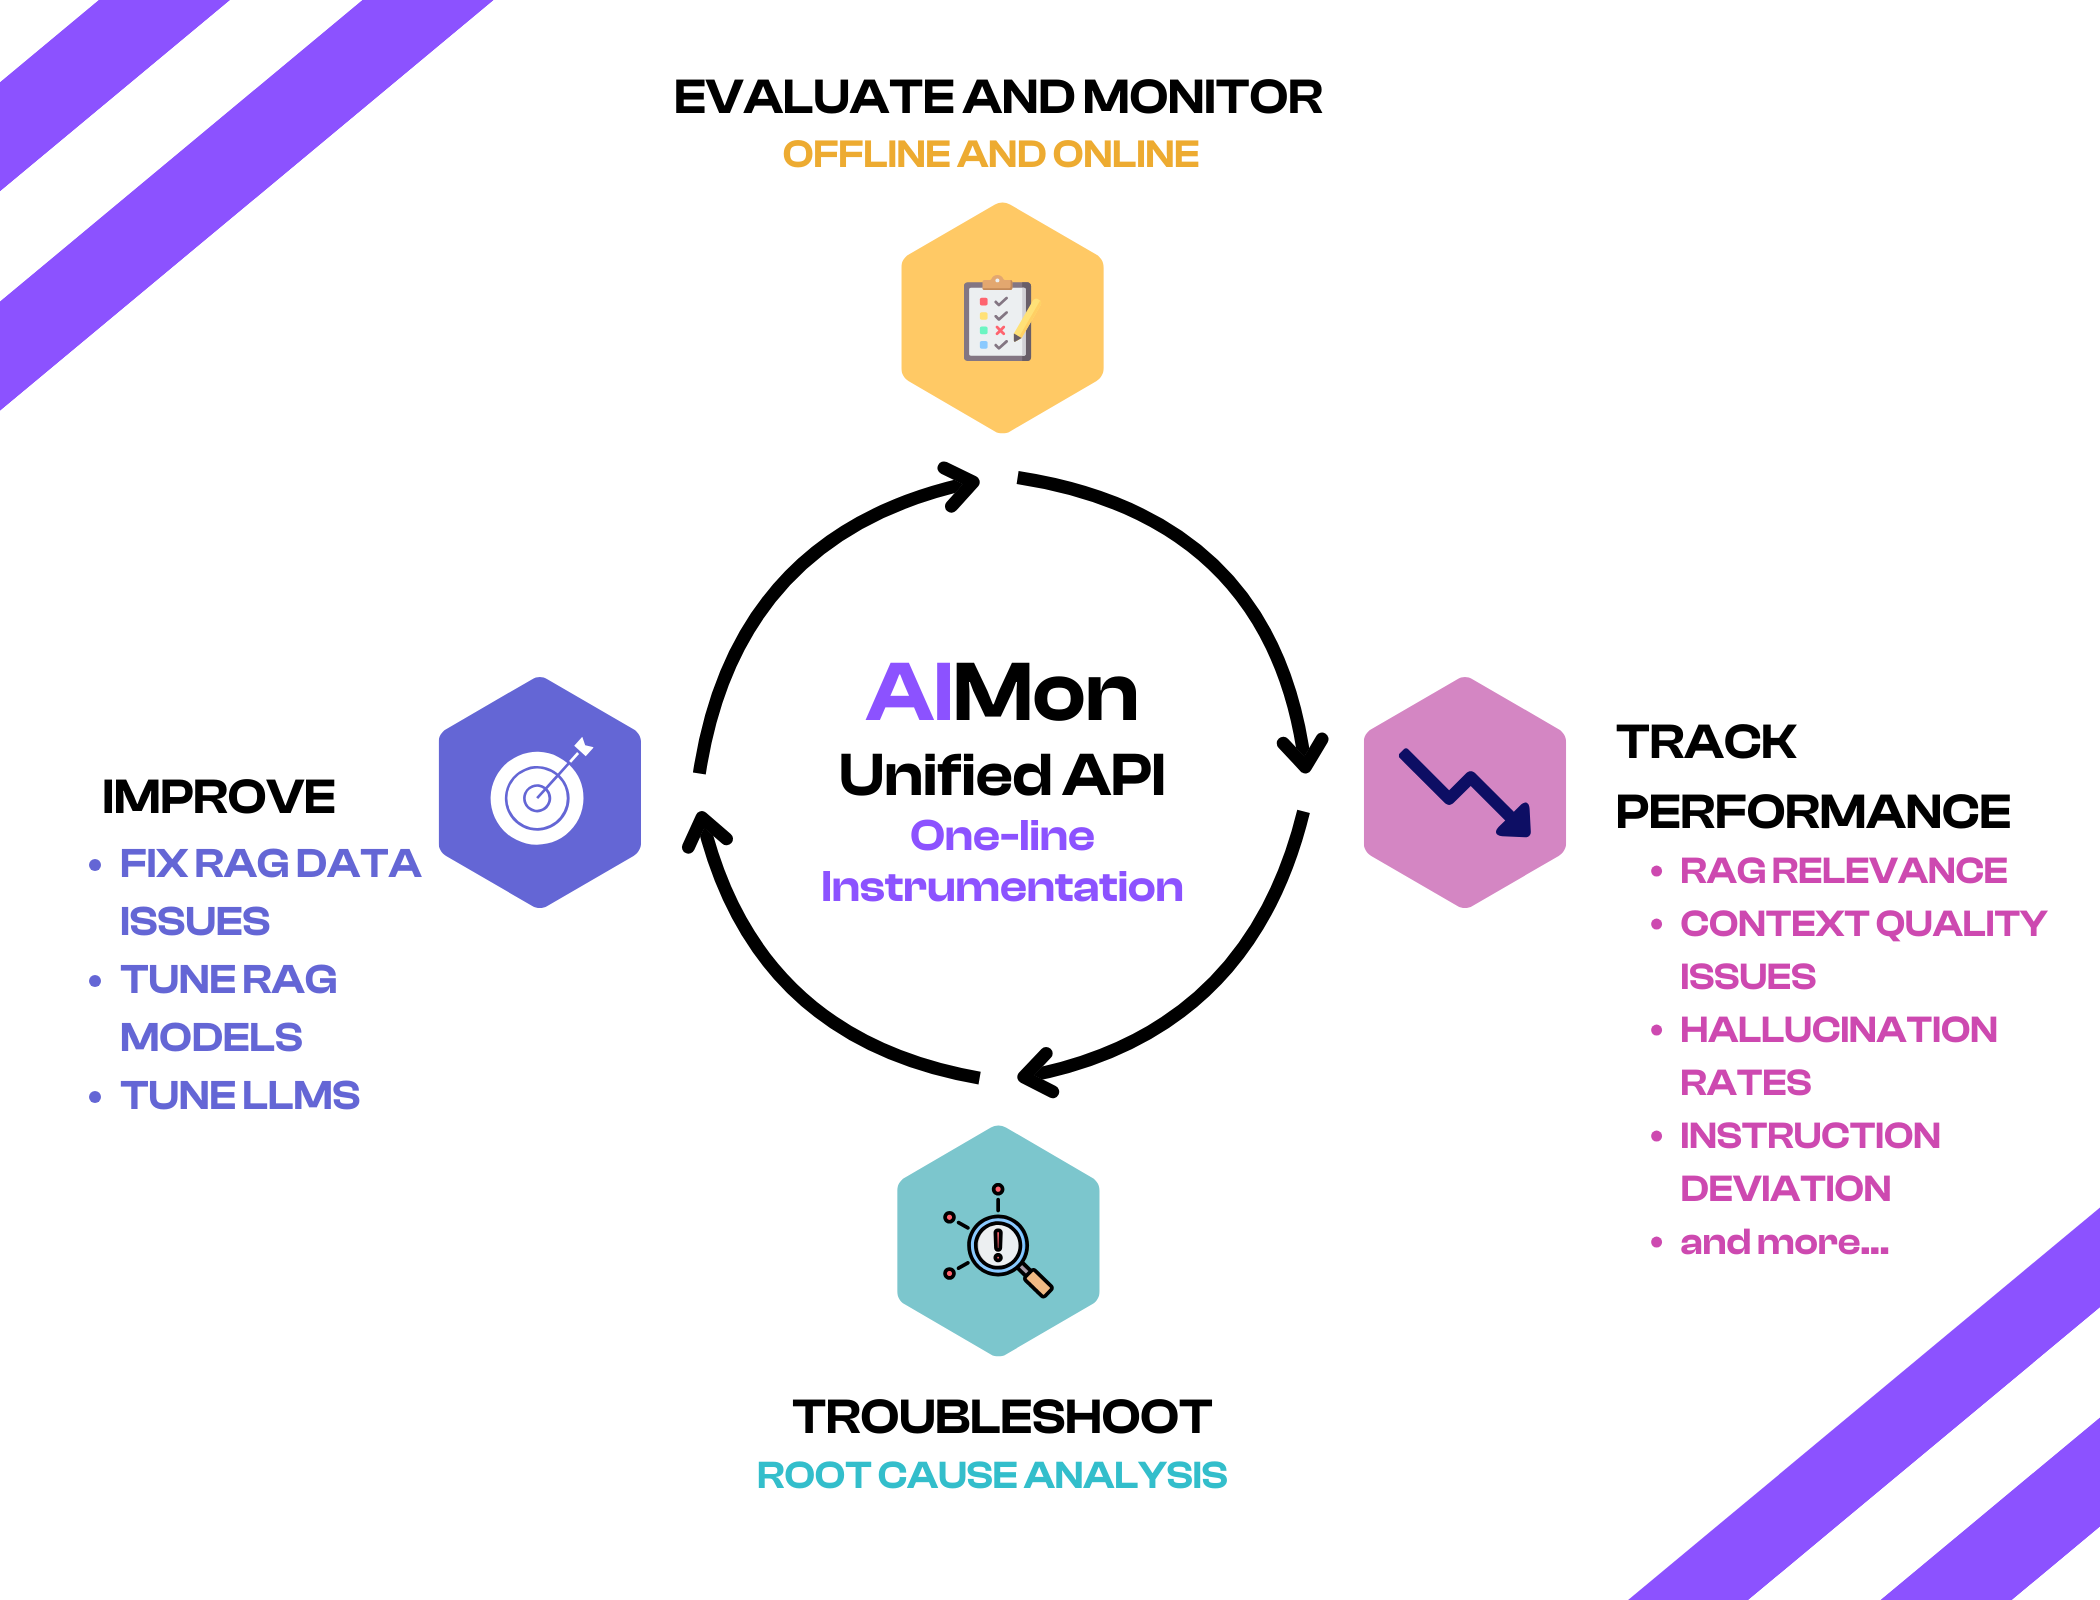